# Minimal Notebook for UnitaryHack lambeq Optimizer challenge

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
EPOCHS = 200
SEED = 0

### Create diagram

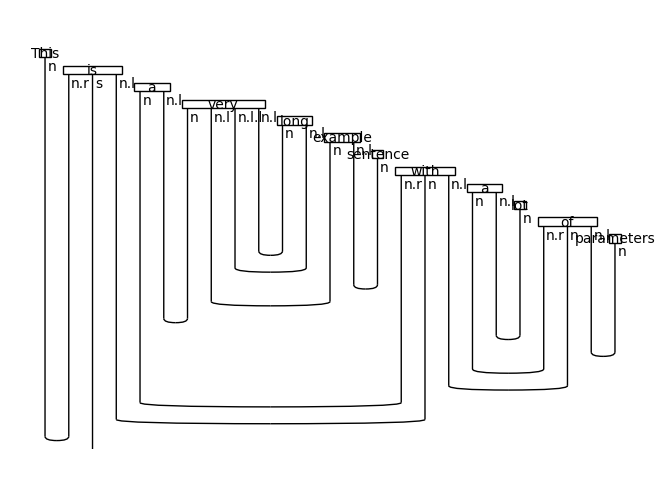

In [3]:
from lambeq import BobcatParser
parser = BobcatParser(verbose='text')
train_diagram = parser.sentence2diagram('This is a very long example sentence with a lot of parameters')
train_diagram.draw()

### Remove the cups

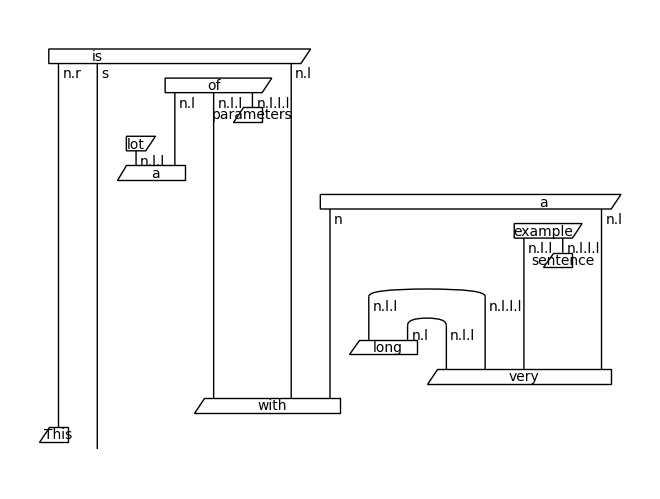

In [4]:
from lambeq import remove_cups

train_diagram = remove_cups(train_diagram)

train_diagram.draw()

### Create circuits

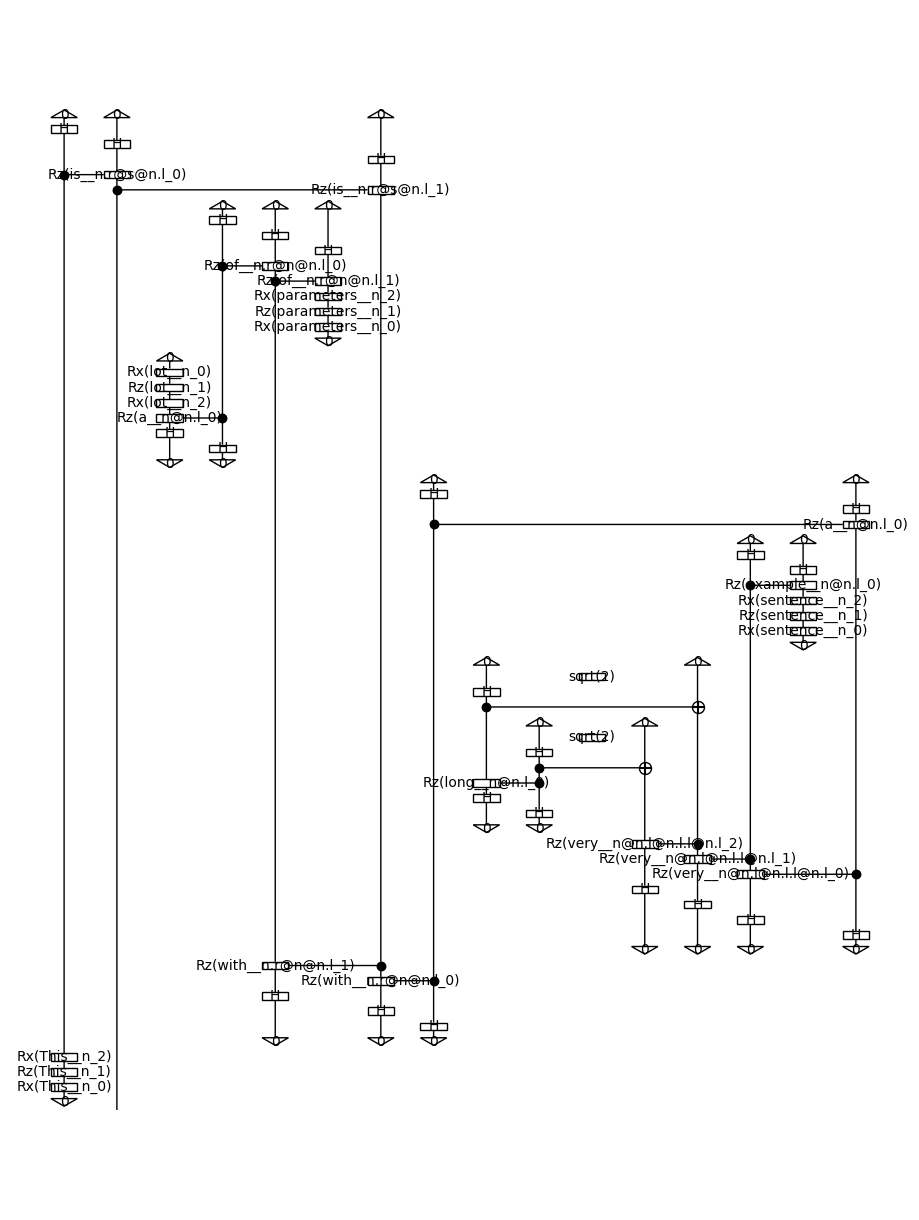

In [5]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuit = ansatz(train_diagram)

train_circuit.draw(figsize=(9, 12))

### Parameterise

In [6]:
from lambeq import NumpyModel

model = NumpyModel.from_diagrams([train_circuit], use_jit=True)

### Define evaluation metric

In [7]:
from jax import jit

@jit
def loss(y_pred, _):
    """The goal is to minimise the expectation value of the Pauli Z operator.
    Unfortunately, DisCoPy does not provide functionality to directly calculate
    expectation values. Therefore, we need to calculate the expectation value
    from the measurement probabilities of the Ket(0) and Ket(1) states which
    are returned from the model's forward pass. The following function does
    exactly that."""

    # 0 state probability
    p0 = y_pred[:, 0]
    # 1 state probability
    p1 = y_pred[:, 1]

    # expectation value
    exp = p0 - p1  # eigenvalues are 1 and -1

    return - exp.mean()  # minimise expectation of measuring a 1


In [8]:
from lambeq import Dataset

train_dataset = Dataset(
            [train_circuit],
            [-1])

### Initialize trainer

TODO: Here you want to test your own optimizer.

In [9]:
from lambeq import QuantumTrainer
from lambeq import NelderMeadOptimizer

losses = []

for i in range(100):  # calculate results for 100 different seeds

    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=NelderMeadOptimizer,  # TODO: Change this to your optimizer
        optim_hyperparams={
            'xtol':1e-6,
            'fatol':1e-6,
        },  # TODO: Modify these hyperparameters as needed
        evaluate_on_train=True,
        verbose = 'suppress',
        seed=i
    )

    trainer.fit(train_dataset, logging_step=12)
    losses.append(trainer.train_epoch_costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Show results

In [10]:
# get mean and std of the losses
import numpy as np

mean_losses = np.mean(losses, axis=0)
std_losses = np.std(losses, axis=0)

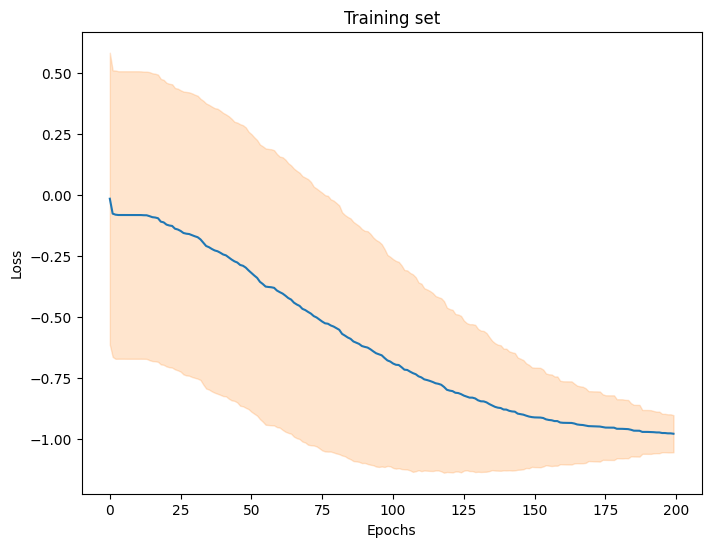

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Training set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.plot(mean_losses, color=next(colours));
ax.fill_between(range(len(mean_losses)), 
                mean_losses-std_losses, 
                mean_losses+std_losses, 
                alpha=0.2, 
                color=next(colours));

## Final Output

In [12]:
model([train_circuit]).round(5)

Array([[0.98555, 0.01445]], dtype=float32)

## Adaptive parameters

In [13]:
model = NumpyModel.from_diagrams([train_circuit], use_jit=True)

In [14]:
losses = []

for i in range(100):  # calculate results for 100 different seeds

    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=NelderMeadOptimizer,  # TODO: Change this to your optimizer
        optim_hyperparams={
            'xtol':1e-6,
            'fatol':1e-6,
            'adaptive':True
        },  # TODO: Modify these hyperparameters as needed
        evaluate_on_train=True,
        verbose = 'suppress',
        seed=i
    )

    trainer.fit(train_dataset, logging_step=12)
    losses.append(trainer.train_epoch_costs)

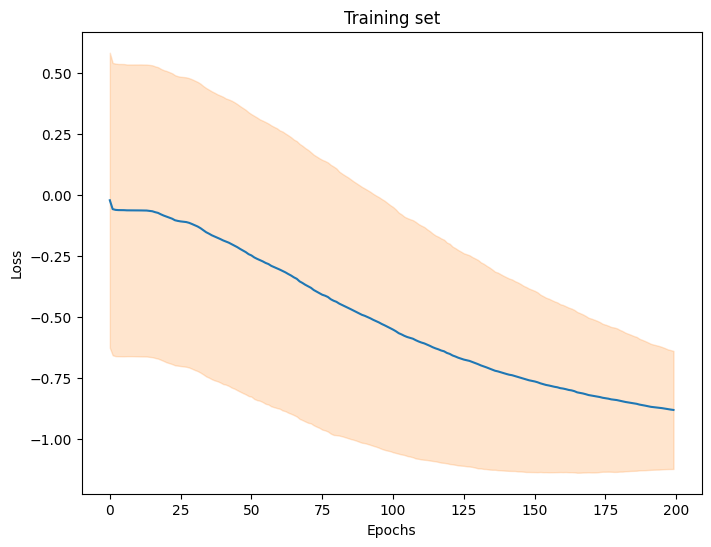

In [15]:
mean_losses = np.mean(losses, axis=0)
std_losses = np.std(losses, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Training set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.plot(mean_losses, color=next(colours));
ax.fill_between(range(len(mean_losses)), 
                mean_losses-std_losses, 
                mean_losses+std_losses, 
                alpha=0.2, 
                color=next(colours));

In [16]:
model([train_circuit]).round(5)

Array([[0.96625, 0.03375]], dtype=float32)